In [1]:
import torch

from torch.utils.data import DataLoader,TensorDataset
from torchvision.datasets import CIFAR10,MNIST
from torchvision.transforms import Compose,ToTensor,Normalize

import numpy as np

from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE

from src.net.triplet_net import TripletNetwork

from src.mininig import offline,online_mine_all
from src.loss_fn import triplet_loss

from src.plot import scatter

In [2]:
device = torch.device('cuda:0')
tsne = TSNE(random_state=0)
batch_size_train = 256

In [3]:
train_loader = DataLoader(CIFAR10('./CIFAR10/',train=True,download=True,
                                 transform=Compose([ToTensor(),Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
                                 ),batch_size=batch_size_train,shuffle=True)

Files already downloaded and verified


In [4]:
test_loader = DataLoader(CIFAR10('./CIFAR10/',train=False,download=True,
                                 transform=Compose([ToTensor(),Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
                                 ),batch_size=batch_size_train,shuffle=False)

Files already downloaded and verified


In [5]:
x_test,y_test = next(iter(test_loader))

In [6]:
temp = x_test.shape[1:]

In [7]:
x_test.size()

torch.Size([256, 3, 32, 32])

In [8]:
y_test.size()

torch.Size([256])

In [9]:
x_test = x_test.to(device)
y_test = y_test.to(device)

In [10]:
x_train,y_train = next(iter(train_loader))
x_train = x_train.to(device)
y_train = y_train.to(device)

In [11]:
train_tsne_embeds = tsne.fit_transform(x_train.flatten(1).cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(x_test.flatten(1).cpu().detach().numpy())

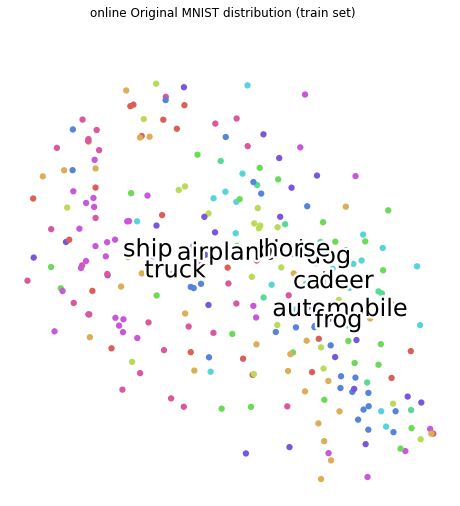

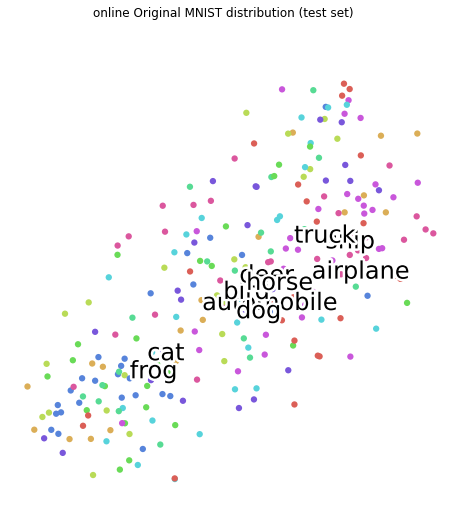

In [12]:
scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'online Original MNIST distribution (train set)', dataset='CIFAR10')
scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'online Original MNIST distribution (test set)', dataset='CIFAR10')

In [13]:
from src.net.simple_triplet_net import SimpleTripletNetwork

In [14]:
model = SimpleTripletNetwork(input_shape=x_train.shape[1:],output_size=128)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-5)

In [15]:
margin = 0.5
for epoch in range(100):
    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader,0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss, pos_triplet, valid_triplet = online_mine_all(labels,outputs,margin=margin,squared=True,device=device)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i%2 == 0:
            print(f"At epoches = {epoch}, i= {i}, loss = {loss:.5f}, trainable_triplet = {pos_triplet},total_triplets = {valid_triplet}",end='\r')
    train_epoch_loss = running_loss / len(train_loader)
#     Evaluating on test set
    print("-"*100)
    running_loss = 0.0
    model.eval()
    for i, data in enumerate(test_loader,0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss, pos_triplet, valid_triplet = online_mine_all(labels,outputs,margin=margin,squared=True,device=device)
        running_loss += loss.item()
        if i % 2 == 0:
            print(f"Evaluating At epoches = {epoch}, i ={i}, loss = {loss:.5f}",end='\r')
    test_epoch_loss = running_loss / len(test_loader)
    print("-"*100)
    print(f"At epoches = {epoch}, epoch_train_loss = {train_epoch_loss:.6f},\t epoch_test_loss = {test_epoch_loss:.6f}")
print("Finished Training")
torch.save(model.state_dict(),"final_model.pth")

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
At epoches = 0, epoch_train_loss = 0.695781,	 epoch_test_loss = 0.526842
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
At epoches = 1, epoch_train_loss = 0.586186,	 epoch_test_loss = 0.505446
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
At epoches = 2, epoch_train_loss = 0.559916,	 epoch_test_loss = 0.499062
----------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
At epoches = 30, epoch_train_loss = 0.499090,	 epoch_test_loss = 0.505241
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
At epoches = 31, epoch_train_loss = 0.500232,	 epoch_test_loss = 0.502631
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
At epoches = 32, epoch_train_loss = 0.496567,	 epoch_test_loss = 0.520547
----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
At epoches = 60, epoch_train_loss = 0.485412,	 epoch_test_loss = 0.551822
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
At epoches = 61, epoch_train_loss = 0.484409,	 epoch_test_loss = 0.552245
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
At epoches = 62, epoch_train_loss = 0.485305,	 epoch_test_loss = 0.551128
----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
At epoches = 90, epoch_train_loss = 0.478214,	 epoch_test_loss = 0.590439
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
At epoches = 91, epoch_train_loss = 0.478600,	 epoch_test_loss = 0.601199
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
At epoches = 92, epoch_train_loss = 0.478364,	 epoch_test_loss = 0.591221
----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------

In [16]:
train_outputs = model(x_train)
test_outputs = model(x_test)

train_tsne_embeds = tsne.fit_transform(train_outputs.cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(test_outputs.cpu().detach().numpy())

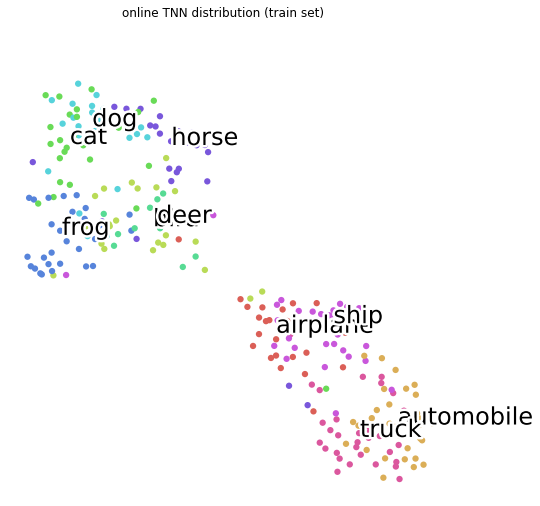

In [17]:
scatter(train_tsne_embeds,y_train.cpu().numpy(),subtitle=f'online TNN distribution (train set)',dataset='CIFAR10')

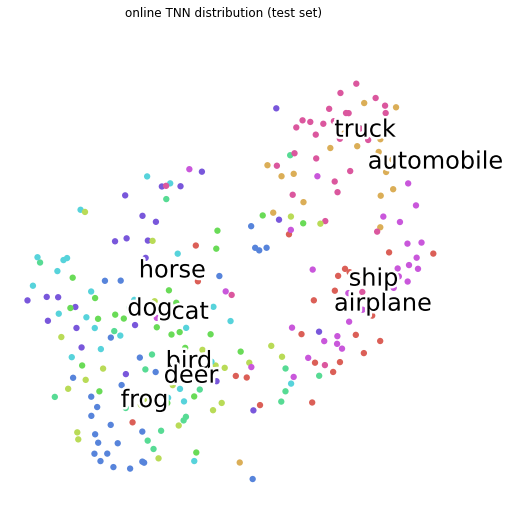

In [18]:
scatter(test_tsne_embeds,y_test.cpu().numpy(),subtitle=f'online TNN distribution (test set)',dataset='CIFAR10')